In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Part 1: Outcomes from No-regret Learning in Games

## Set Up and Algorithm Definition

In [385]:
class EWAlg:
    def __init__(self, epsilon, k, h, myBids, myValue):
        self.weights = np.ones(k)
        self.payoffs = np.zeros(k)
        self.h = h
        self.k = k
        self.epsilon = epsilon
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myValue = myValue
        self.myBids = myBids
        self.myTotalValue = 0

    def getBids(self):
        return self.myBids

    def getValue(self):
        return self.myValue

    def getTotalValue(self):
        return self.myTotalValue

    def getAction(self):
        j = np.random.choice(self.k, 1, p = self.probs)
        return self.myBids[j.item()]
    
    def update(self, payoffs):
        for j in range(len(payoffs)):
            curPayoff = payoffs[j]
            self.payoffs[j] = self.payoffs[j] + curPayoff
            newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
            self.weights[j] = newWeight
        self.sumWeights = np.sum(self.weights)
        self.weights = self.weights/self.sumWeights
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        return

    def generatePayoffs(self, bidToBeat, winningBid, meWin):
        if meWin:
            self.myTotalValue += self.myValue - winningBid
        payoffs = np.zeros(self.k)
        for count, bid in enumerate(self.myBids):
            if bid >= bidToBeat:
                payoffs[count] = self.myValue - bid
            else:
                payoffs[count] = 0
        return payoffs
    
    def reset(self):
        self.weights = np.ones(self.k)
        self.payoffs = np.zeros(self.k)
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myTotalValue = 0


In [373]:
class FirstPriceReserve:
    # bidders have to be ordered the same way every time
    # reserve given as a raw value
    def __init__(self, numBidders, reserve = 0):
        self.numBidders = numBidders
        self.totalPayoffs = np.zeros(self.numBidders)
        self.reserve = reserve
        
    def generate(self, bids):
        # set winning bid to reserve price
        winningBid = self.reserve
        winner = -1
        tiedBidders = []
        tied = False
        generatedBids = bids
        generatedBids.append(self.reserve)
        # check bids of all bidders
        for count, bid in enumerate(bids):
            if bid > winningBid:
                winningBid = bid
                winner = count
            elif (bid == winningBid) and (winner != -1):
                tiedBidders.append(count)
                tied = True
        if tied : winner = random.choice(tiedBidders)
        return [generatedBids, winningBid, winner]

In [431]:

def setUpPlayers() :
    # set up our players
    players = []
    for count in range(numPlayers):
    # pick a distribution and numPlayers values from it
        playerValue = random.uniform(min,h) # use values[count] if you want to use hardcoded values
        # create possible bids using geometric discretization
        playerBids = []
        for j in range(k):
            playerBids.append(playerValue - ((1 + stepSize)**(-j))*playerValue)
        # create player
        player = EWAlg(epsilons[count], k, h, playerBids, playerValue )
        players.append(player)
    return players

def conductAuction(players, auction, n = 100):
    # do the action n times
    allBidsCA = []
    allWinners = []
    for i in range(n):
        bids = []
        # generate bids
        for count, player in enumerate(players):
            bids.append(player.getAction())
        currbids = bids.copy()
        
        
        # conduct auction
        results = auction.generate(currbids) #<-- somehow an extra 0 is getting added to the list
        roundBids = results[0]
        winningBid = results[1]
        winner = results[2]
        allWinners.append(winner)
        # update payoffs
        for count, player in enumerate(players):
            oppositionBids = roundBids.copy()
            oppositionBids[count] = 0
            bidToBeat = max(oppositionBids)
            if count == winner:
                payoffs = player.generatePayoffs(bidToBeat, winningBid, True)
            else:
                payoffs = player.generatePayoffs(bidToBeat, winningBid, False)
            player.update(payoffs)
        allBidsCA.append(bids)
    return allBidsCA, allWinners

In [433]:
# set hyperparameters
numPlayers = 2
n = 500
epsilons = [0.2,0.088]
h = 10
min = 1
k = 50
stepSize = np.log(h) / k
values = [6.134906265277637, 2.4808651504511428] # if you want to use hardcoded values

MCBound = 500
reserveFrac = 0 #between 0 and 1
reserveValue = reserveFrac * (h + min)


# set up players
players = setUpPlayers()
# set up the auction 
auction = FirstPriceReserve(2, reserveValue)


values = []
totalWinnings = [[], []]
possibleBids = []
for player in players:
    values.append(player.getValue())
    possibleBids.append(player.getBids())

MCBids = []
MCWinners = []
for i in range(MCBound):
    # conduct auction
    allBids, allWinners = conductAuction(players, auction, n)
    # print("all bids = ", allBids)
    for count, player in enumerate(players):
        totalWinnings[count].append(player.getTotalValue())
        # print(player.getTotalValue())
    # reset players -> they keep same learning rate and values
    for player in players:
        player.reset()
    MCBids.append(allBids)
    MCWinners.append(allWinners)
avgBids = np.array(MCBids)
avgBids = np.mean(avgBids, 0)
totalWinnings = np.mean(np.array(totalWinnings), 1)

print(values)
print(totalWinnings)
#print(avgBids)
# print(MCBids)

[6.134906265277637, 2.4808651504511428]
[1751.6754545     6.04232962]


In [434]:
for player in players:
    print(player.myBids)

[0.0, 0.27008500035376404, 0.5282796955811149, 0.775107548132075, 1.0110689753847621, 1.236642364188726, 1.4522850407437131, 1.6584341977801902, 1.85550778092139, 2.0439053360238804, 2.2240088192145477, 2.39618337126627, 2.560778057882234, 2.7181265773897443, 2.8685479372783083, 3.012347100953598, 3.149815606018515, 3.281232155334861, 3.406863182063929, 3.5269633898315718, 3.6417762691128774, 3.7515345908833675, 3.8564608785375434, 3.9567678590315447, 4.052658894164565, 4.144328392873401, 4.231962205376021, 4.315737999963237, 4.395825623202377, 4.472387444283251, 4.545578684204516, 4.615547730467843, 4.682436437917887, 4.746380416337994, 4.807509305384695, 4.8659470374184135, 4.921812088763213, 4.975217719905031, 5.026272205115335, 5.075079051965762, 5.121737211178781, 5.166341277239817, 5.208981680177579, 5.249744868901375, 5.28871348646714, 5.325966537627497, 5.3615795490055405, 5.395624722217078, 5.428171080251777, 5.459284607409977]
[0.0, 0.10921837043045945, 0.21362847772847182, 0

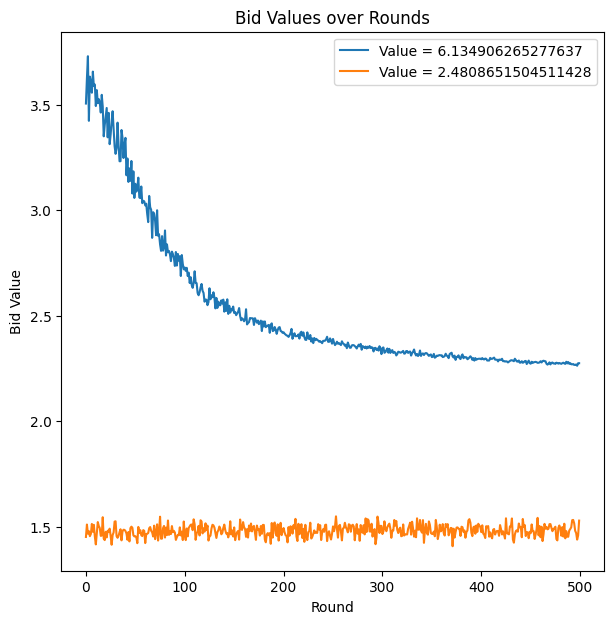

In [435]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)

newBids = [[], []]
for i in range(n):
    newBids[0].append(avgBids[i][0])
    newBids[1].append(avgBids[i][1])

plt.plot(np.arange(n), newBids[0], label = "Value = " + str(values[0]))
plt.plot(np.arange(n), newBids[1], label = "Value = " + str(values[1]))
plt.title('Bid Values over Rounds')
plt.xlabel('Round')
plt.ylabel('Bid Value')
plt.legend()
plt.show()
# f.savefig('RegretvRoundAf.png')

## Manipulating a No-Regret Learner

In [428]:
class Adversary:
    def __init__(self, epsilon, k, h, myBids, myValue):
        self.h = h
        self.k = k
        self.curRound = 0
        self.epsilon = epsilon
        self.myValue = myValue
        self.myBids = myBids
        self.myTotalValue = 0

    def getBids(self):
        return self.myBids

    def getValue(self):
        return self.myValue

    def getTotalValue(self):
        return self.myTotalValue

    def getAction(self):
        if (self.curRound < self.epsilon):
            j = 0 
        else: 
            j = 20
        return self.myBids[j]
    
    def update(self, payoffs):
        self.curRound += 1
        if self.curRound > self.epsilon + 1:
            self.curRound = 0
        return

    def generatePayoffs(self, bidToBeat, winningBid, meWin):
        if meWin:
            self.myTotalValue += self.myValue - winningBid
        payoffs = np.zeros(self.k)
        return payoffs
    
    def reset(self):
        self.myTotalValue = 0

In [429]:
# set hyperparameters
numPlayers = 2
n = 500
epsilons = [0.2]
values = [6.134906265277637, 2.4808651504511428]
h = 10
min = 1
k = 50
stepSize = np.log(h) / k

MCBound = 500
reserveFrac = 0 #between 0 and 1
reserveValue = reserveFrac * (h + min)


# set up players
players = []
for count in range(numPlayers - 1):
# pick a distribution and numPlayers values from it
    playerValue = random.uniform(5,h) # values[count] if using hardcoded values
    # create possible bids using geometric discretization
    playerBids = []
    for j in range(k):
        playerBids.append(playerValue - ((1 + stepSize)**(-j))*playerValue)
    # create player
    player = EWAlg(epsilons[count], k, h, playerBids, playerValue )
    players.append(player)
# set up adversary player
playerValue = random.uniform(min,5) # values[1] 
playerBids = []
for j in range(k):
    playerBids.append(playerValue - ((1 + stepSize)**(-j))*playerValue)
adversary = Adversary(10, k, h, playerBids, playerValue )
players.append(adversary)

# set up the auction 
auction = FirstPriceReserve(numPlayers, reserveValue)


values = []
totalWinnings = [[], []]
possibleBids = []
for player in players:
    values.append(player.getValue())
    possibleBids.append(player.getBids())

MCBids = []
MCWinners = []
for i in range(MCBound):
    # conduct auction
    allBids, allWinners = conductAuction(players, auction, n)
    for count, player in enumerate(players):
        totalWinnings[count].append(player.getTotalValue())
    # reset players -> they keep same learning rate and values
    for player in players:
        player.reset()
    MCBids.append(allBids)
    MCWinners.append(allWinners)
avgBids = np.array(MCBids)
avgBids = np.mean(avgBids, 0)
totalWinnings = np.mean(np.array(totalWinnings), 1)

print(values)
print(totalWinnings)
#print(avgBids)
# print(MCBids)

[6.134906265277637, 2.4808651504511428]
[986.49368765  71.37948473]


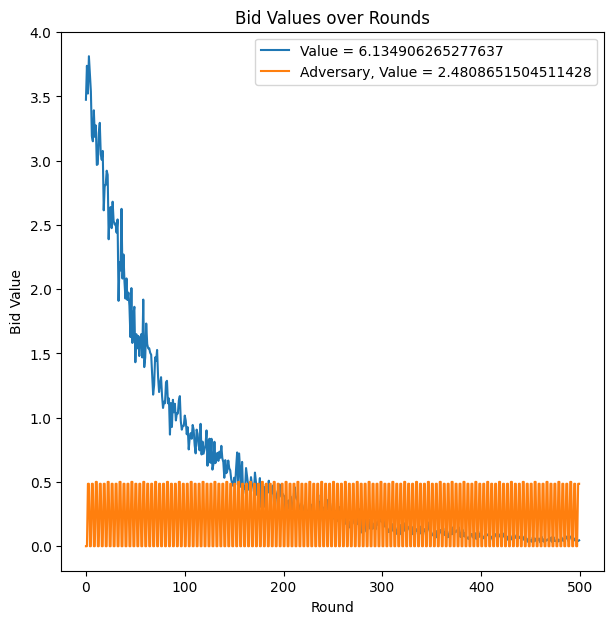

In [430]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)

newBids = [[], []]
for i in range(n):
    newBids[0].append(avgBids[i][0])
    newBids[1].append(avgBids[i][1])

plt.plot(np.arange(n), newBids[0], label = "Value = " + str(values[0]))
plt.plot(np.arange(n), newBids[1], label = "Adversary, Value = " + str(values[1]))
plt.title('Bid Values over Rounds')
plt.xlabel('Round')
plt.ylabel('Bid Value')
plt.legend()
plt.show()
# f.savefig('RegretvRoundAf.png')